In [24]:
import li
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import constants as const

In [2]:
# path to images

# program tested for: path_dir = 'Z:/Archiv/2D/Experiment/2024/20241105/Images20241105/B-Micro1Z_scan/'
# program working for: path_dir = 'Z:/Archiv/2D/Experiment/2024/20241106/Images20241106/A_MicroScan1_AfterDMD/'

# path_dir_from_BACKUP = 'Z:/Archiv/2D/Experiment/2024/20241107/Images20241107/A-Micro_2_Z_Set_scan_1_5us/'

# path to images
# images_set = "B-inSitu_cold_imaging_832"
# date = "20250226"

images_set = "D_ImageResolution"
date = "20250321"

path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

print(len(path_file))

path_file = os.listdir(path_dir)

75


In [4]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[-1])[1]
var_vals = la.loop_variables(path_dir + path_file[-1])[0]

for i, var in enumerate(variables):
    print(f"{var}: {var_vals[i][0]} - {var_vals[i][-1]}, {len(var_vals[i])}")

i: 100.0 - 10.0, 10


In [5]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[0])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))

# Image Procesing

In [6]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 0 ns
Wall time: 29.2 ms


50.0


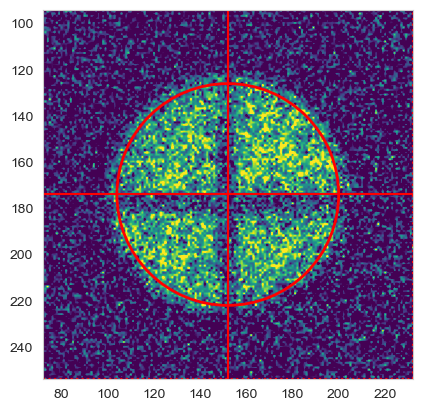

In [81]:
# determine optimal ROI
center = (174, 152)
h = 80
w = 80

line = 165

image_num = 11

single_prc = la.density_builder([images_raw[image_num]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")
print(single_prc.iloc[0]["i"])

circle = plt.Circle((center[1], center[0]), 48, color='r', fill=False, lw = 2)
plt.gca().add_artist(circle)

plt.xlim(center[1] - w, center[1] + w)
plt.ylim(center[0] + h, center[0] - h)

# line
# plt.axhline(line, c = "red")

plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")

plt.grid(False)

plt.show()

In [11]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 15/15 [100%] in 3.9s (3.83/s)        
CPU times: total: 1.47 s
Wall time: 3.94 s


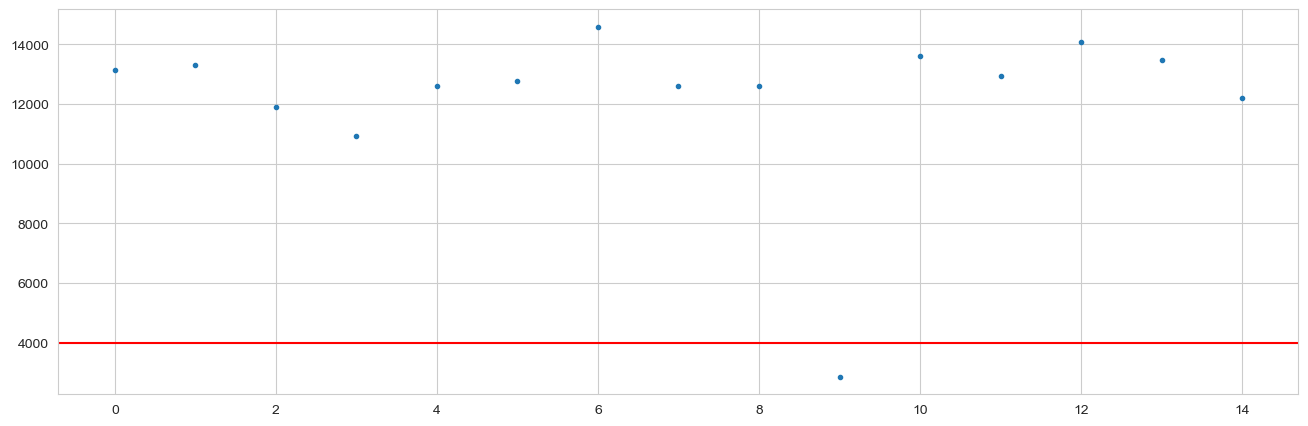

15


In [14]:
# filter out missed shots
bol = []


for val in var_vals[0]:

    mask = (np.isclose(images_prc["i"], val))

    for i, im in images_prc[mask].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(4000, c = "r")

plt.ylim(None, None)

plt.show()

print(len(bol))

In [15]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 4000)

CPU times: total: 0 ns
Wall time: 9 ms


In [3]:
# prepare image and Z position arrays

# select just the Reinaudi images
Reinaudi = [file for file in path_file if "Reinaudi" in file]

# remove .png tail
Z_set = [file[:-4] for file in Reinaudi]

# use the actual values as names
Z_set = [zs.split("_")[-1] for zs in Z_set]

# turn values into integers and put them in a numpy array
Z_set = [float(zs) for zs in Z_set]

# sort values and Reinaudi images
sorting = np.argsort(Z_set)

Reinaudi = np.array(Reinaudi)[sorting]
Z_set = np.array(Z_set)[sorting]

In [34]:
# gaussian: for fitting the density dip in atomic cloud
# def gauss(x, mu, sigma, a, b):
#     return a * 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x - mu)/sigma)**2) + b

# gaussian: for fitting the density dip in atomic cloud
def gauss(x, mu, w, a, b):
    return a * np.exp(-2 * ((x - mu)/w)**2) + b

def rayleigh(x, mu, xR, w0, a):
    return w0 * np.sqrt(1 + ((x - mu)/xR)**2) + a

# parabola: for fitting the sharpness curve
def parabola(x, mu, a, b, c):
    return a + b*(x - mu) + c*(x - mu)**2

In [82]:
# x values for gaussian fit of dip
x1 = 140
x2 = 165
x = np.arange(x1, x2)

# vertical position of red line
line = 165

# sharpness of the dip i.e. width of the dip
sharpness = []

# dynamic shift of gaussian peak due to microscope position
# shift = np.linspace(45, 52, len(Z_set))

image_select = 0 # plot for selected image
# if all images are to be plotted, outdent if-statement

for i, im in images_fil.iterrows():

    profile = np.sum(im["density"][:line], axis = 0)
    popt, pcov = curve_fit(gauss, x, profile[x1:x2], p0 = [center[1], 2, -20, 10])

    sharpness.append(np.abs(popt[1]))

    # if i == image_select:

    # plt.plot(profile)
    # plt.plot(x, profile[x1:x2])
    # plt.plot(np.linspace(x1, x2, 100), gauss(np.linspace(x1, x2, 100), popt[0], popt[1], popt[2], popt[3]))
    # plt.axvline(140)
    # plt.axvline(165)

    # print(i, Z_set[i], popt)
    # plt.show()

    # print(im["i"])
    # print("")

sharpness = np.array(sharpness)

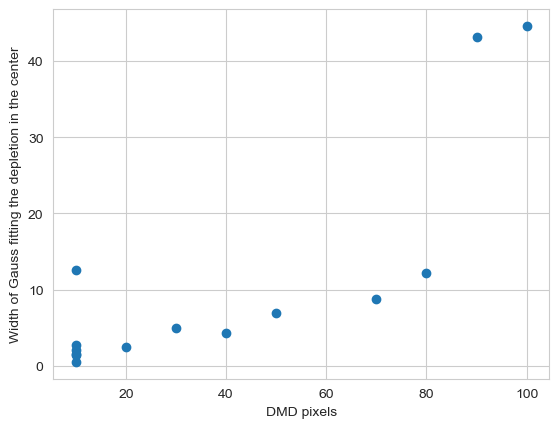

In [83]:
# sharpness curve
# two images taken per position
# sometimes there is onlyh one position if the one has been filtered out

# plt.plot(images_fil["i"][:-4], sharpness[:-4])
plt.scatter(images_fil["i"], sharpness)

plt.xlabel("DMD pixels")
plt.ylabel("Width of Gauss fitting the depletion in the center")

plt.show()

In [12]:
# average values sharpness values for same Z_set if available
Z_set_unique = np.unique(Z_set)

sharpness_avg = []

for i, position in enumerate(Z_set_unique):

    mask = (Z_set == position)
    sharpness_position = sharpness[mask]

    sharpness_avg.append(np.average(sharpness_position))

sharpness_avg = np.array(sharpness_avg)

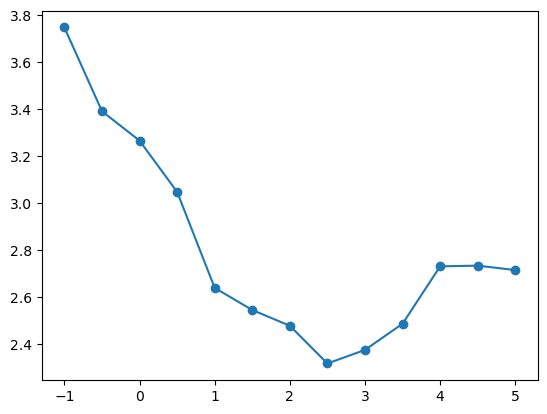

In [13]:
# plot average sharpness per position

ROI_sharpness_1 = 0
ROI_sharpness_2 = 100

plt.plot(Z_set_unique[ROI_sharpness_1:ROI_sharpness_2], sharpness_avg[ROI_sharpness_1:ROI_sharpness_2])
plt.scatter(Z_set_unique[ROI_sharpness_1:ROI_sharpness_2], sharpness_avg[ROI_sharpness_1:ROI_sharpness_2])
plt.show()

In [14]:
# fit sharpness curve with parabola
# popt, pcov = curve_fit(parabola, Z_set_unique[ROI_sharpness_1:ROI_sharpness_2], sharpness_avg[ROI_sharpness_1:ROI_sharpness_2], p0 = [0, 1.3, 1, 1])
popt, pcov = curve_fit(rayleigh, Z_set_unique[ROI_sharpness_1:ROI_sharpness_2], sharpness_avg[ROI_sharpness_1:ROI_sharpness_2], p0 = [3, 1, 1.3, 1])

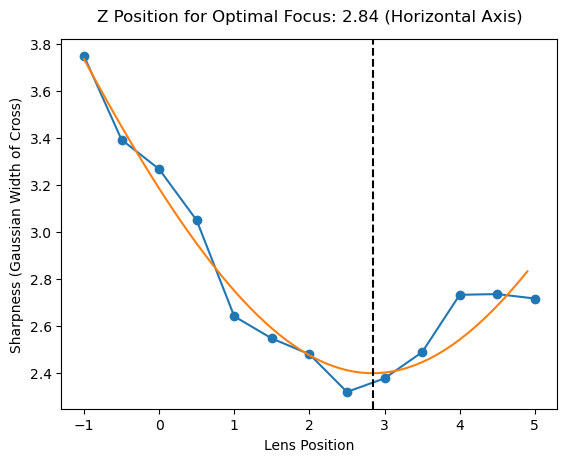

In [15]:
plt.plot(Z_set_unique[ROI_sharpness_1:ROI_sharpness_2], sharpness_avg[ROI_sharpness_1:ROI_sharpness_2])
plt.scatter(Z_set_unique[ROI_sharpness_1:ROI_sharpness_2], sharpness_avg[ROI_sharpness_1:ROI_sharpness_2])

# plt.plot(np.arange(Z_set_unique[0], Z_set_unique[-1], 0.1), parabola(np.arange(Z_set_unique[0], Z_set_unique[-1], 0.1), popt[0], popt[1], popt[2], popt[3]))
plt.plot(np.arange(Z_set_unique[0], Z_set_unique[-1], 0.1), rayleigh(np.arange(Z_set_unique[0], Z_set_unique[-1], 0.1), popt[0], popt[1], popt[2], popt[3]))

# position for optimal focus (parabola)
# minimum = (2*popt[3] * popt[0] - popt[2]) / (2*popt[3])

# position for optimal focus (rayleigh)
minimum = popt[0]

plt.axvline(minimum, color = "black", ls = "--")

plt.title(f"Z Position for Optimal Focus: {minimum:.2f} (Horizontal Axis)", pad = 13)
plt.xlabel("Lens Position")
plt.ylabel("Sharpness (Gaussian Width of Cross)")

plt.show()